In [6]:
import time

import elfi
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 20170530  # this will be separately given to ELFI
np.random.seed(seed)

In [7]:
def exp_decay(x, param):
    return param[0]*np.exp(-param[1] * x)


def power_law(x, t1, t2):
    return t1 * (x+1)**(-t2)


def exp_decay_one_param(x, param):
    return np.exp(-param[0] * x)

In [8]:
def power_law_one_param(x, param):
    return (x+1)**(-param[0])

In [9]:
def simulate(t1, t2, n_obs=100, batch_size=1, random_state=None):
    
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random
    r = random_state.random((batch_size, n_obs))
    x = np.linspace(1, 1000, n_obs)
    y = power_law(x, t1, t2) > r
    return y

In [10]:
# def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
#     # Make inputs 2d arrays for numpy broadcasting with w
#     t1 = np.asanyarray(t1).reshape((-1, 1))
#     t2 = np.asanyarray(t2).reshape((-1, 1))
#     random_state = random_state or np.random

#     w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
#     x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
#     return x

In [11]:
true_t1, true_t2 = (0.9025, 0.4861)

y_obs = simulate(t1=true_t1, t2=true_t2)

In [12]:
# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
t1 = elfi.Prior(scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior(scipy.stats.uniform, 0, 2)

In [13]:
Y = elfi.Simulator(simulate, t1, t2, observed=y_obs)

In [14]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

In [15]:
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2

In [16]:
# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)

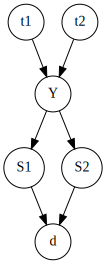

In [17]:
elfi.draw(d)  # just give it a node in the model, or the model itself (d.model)

In [18]:
smc = elfi.SMC(d, batch_size=10000, seed=seed)

In [19]:
N = 1000
schedule = [0.7, 0.2, 0.05]

# You can give the sample method a `vis` keyword to see an animation how the prior transforms towards the
# posterior with a decreasing threshold.
%time result = smc.sample(N, schedule)

INFO:elfi.methods.parameter_inference:---------------- Starting round 0 ----------------


ABC-SMC Round 1 / 3


INFO:elfi.methods.parameter_inference:---------------- Starting round 1 ----------------


Progress [==================================================] 100.0% Complete

ABC-SMC Round 2 / 3


INFO:elfi.methods.parameter_inference:---------------- Starting round 2 ----------------


Progress [==================================================] 100.0% Complete

ABC-SMC Round 3 / 3
Progress [==================================================] 100.0% Complete
CPU times: user 640 ms, sys: 92.1 ms, total: 732 ms
Wall time: 855 ms


In [20]:
result.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 30000
Threshold: 0.0144
Sample means: t1: 1.12, t2: 0.454

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 10000
Threshold: 0.0202
Sample means: t1: 1.2, t2: 0.587

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 10000
Threshold: 0.0144
Sample means: t1: 1.18, t2: 0.492

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 10000
Threshold: 0.0144
Sample means: t1: 1.12, t2: 0.454


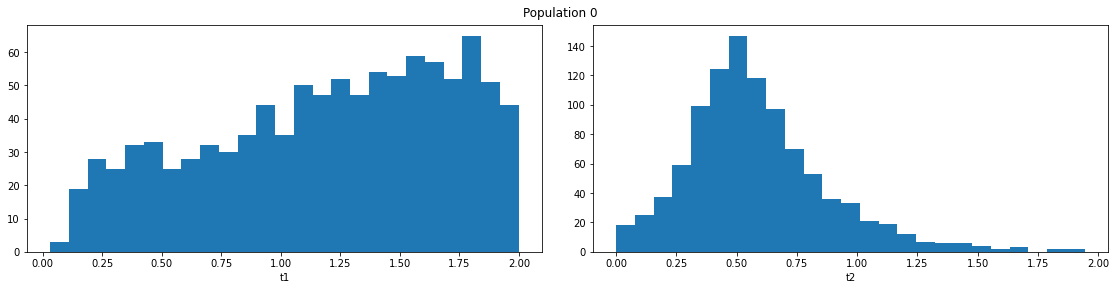

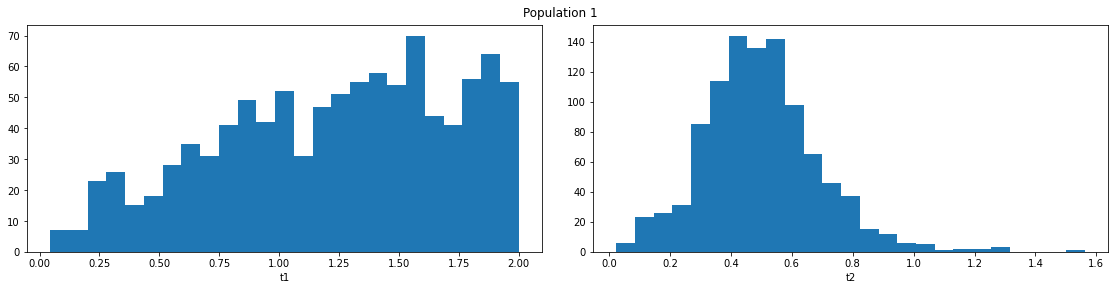

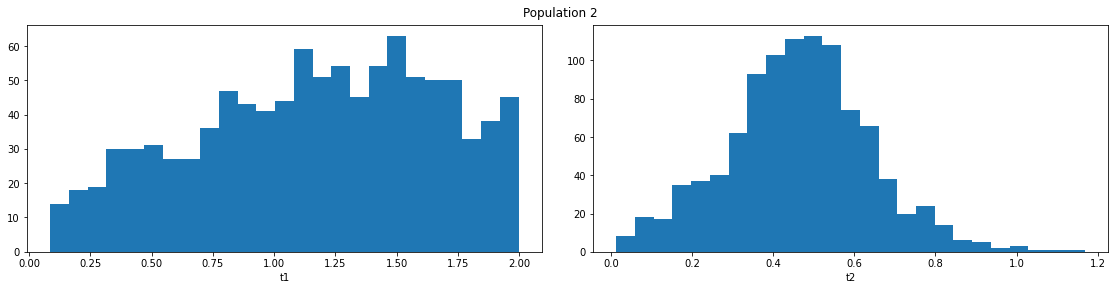

In [21]:
result.plot_marginals(all=True, bins=25, figsize=(8, 2), fontsize=12)